In [4]:
%config IPCompleter.greedy = True

In [27]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torchvision 
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import time

In [137]:
device = torch.device("cuda:0")

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [133]:
train_data = datasets.ImageFolder(root = "data/training_set", transform=transform)
test_data = datasets.ImageFolder(root = "data/test_set", transform=transform)

trainloader = DataLoader(train_data, shuffle = True, batch_size = 64, num_workers = 2)
testloader = DataLoader(test_data, shuffle = True, batch_size = 64, num_workers = 2)

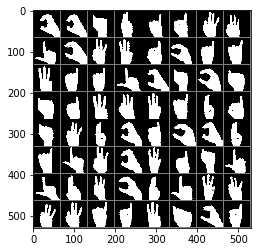

tensor([1, 1, 0, 5, 3, 3, 2, 2, 4, 1, 2, 6, 3, 1, 3, 3, 6, 3, 3, 4, 1, 0, 1, 0,
        0, 3, 6, 2, 6, 3, 5, 3, 0, 2, 5, 1, 3, 1, 1, 5, 3, 4, 2, 1, 6, 3, 0, 4,
        4, 5, 2, 1, 5, 4, 6, 2, 2, 2, 3, 3, 6, 0, 1, 3])


In [128]:
def show_image(img):
    img = img.numpy()
    img = np.transpose(img, (1,2,0))
    img = img*0.5 + 0.5
    plt.imshow(img)
    plt.show()

trainiter = iter(trainloader)
img, label = next(trainiter)

show_image(torchvision.utils.make_grid(img))
print(label)

In [129]:
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        
        self.fc1 = nn.Linear(12544, 256)
        self.dropout = nn.Dropout(p = 0.5)
        self.fc2 = nn.Linear(256, 7)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        
        x = x.view(-1, self.num_features(x))
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.softmax(self.fc2(x), dim = 1)
        
        return x
    
    def num_features(self, x):
        out = 1
        for i in x.size()[1:]:
            out*=i
        return out

In [130]:
def give_model(model_name):
    net = model_name()
    net.to(device)
    print(net)
    return net

In [131]:
def train_model(model, optimizer, epochs = 5):
    start = time.time()
    for epoch in range(epochs):
        e_start = time.time()
        print(f'Epoch - {epoch+1}/{epochs}')
        print('-'*20)
        for phase in ['train', 'eval']:
            
            running_loss = 0.0
            running_correct = 0
            
            if phase == 'train':
                model.train()
                for data in trainloader:
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)
                    
                    optimizer.zero_grad()
                    output = model(inputs)
                    _, pred = torch.max(output, 1)

                    loss = criterion(output, labels)
                    loss.backward()
                    optimizer.step()
                    
                    running_loss += loss.item()
                    running_correct += torch.sum(pred == labels.data)
                    
                epoch_loss = running_loss/len(train_data)
                acc = (running_correct.double()/len(train_data))*100
                
            elif phase == 'eval':
                model.eval()
                with torch.no_grad():
                    for data in testloader:
                        inputs, labels = data
                        inputs, labels = inputs.to(device), labels.to(device)

                        optimizer.zero_grad()
                        output = model(inputs)
                        _, pred = torch.max(output, 1)

                        loss = criterion(output, labels)
                        
                        running_loss += loss.item()
                        running_correct += torch.sum(pred == labels.data)
                        
                    epoch_loss = running_loss/len(test_data)
                    acc = (running_correct.double()/len(test_data))*100
                    
            e_end = time.time()-e_start
            print(f'{phase}: loss - {epoch_loss:3.2f} acc - {acc:3.2f} , Time - {e_end:.2f}')
    end = time.time() - start
    print(f'Training time - {end:.2f}')
    return model

In [138]:
net = give_model(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01)

model_trained = train_model(net, optimizer, 5)

model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12544, out_features=256, bias=True)
  (dropout): Dropout(p=0.5)
  (fc2): Linear(in_features=256, out_features=7, bias=True)
)
Epoch - 1/5
--------------------
train: loss - 0.03 acc - 56.51 , Time - 3.57
eval: loss - 0.03 acc - 75.66 , Time - 4.20
Epoch - 2/5
--------------------
train: loss - 0.02 acc - 89.60 , Time - 3.60
eval: loss - 0.02 acc - 91.14 , Time - 4.26
Epoch - 3/5
--------------------
train: loss - 0.02 acc - 95.90 , Time - 3.58
eval: loss - 0.02 acc - 95.37 , Time - 4.27
Epoch - 4/5
--------------------
train: loss - 0.02 acc - 97.17 , Time - 4.11
eval: loss - 0.02 acc - 98.74 , Time - 4.80
Epoch - 5/5
--------------------
train: loss - 0.02 acc - 98.58 , Time - 4.00
eval: loss - 0.02 acc - 99.20 , Time - 4.66
Training time - 22.19


In [141]:
torch.save(net, "gesture.pt")

/home/user/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
